Question 1:

Autoencoders: In this task, consider the MNIST dataset for training autoencoder models (with
a suitable regularization) with hidden (latent) dimension of 32, and 64. [10 + 5 = 15 Marks]

(a) Report the train and test reconstruction errors for the three models (display about 10 recon-
structions from the train and test data each).


In [1]:
import torch
from torch import nn, optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [2]:
mnist_transforms = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,), (0.5,))])

training_dataset = datasets.MNIST(root='./mnist_data', train=True, download=True, transform=mnist_transforms)
testing_dataset = datasets.MNIST(root='./mnist_data', train=False, transform=mnist_transforms)


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 16171813.58it/s]


Extracting ./mnist_data/MNIST/raw/train-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 486781.97it/s]


Extracting ./mnist_data/MNIST/raw/train-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4405646.53it/s]


Extracting ./mnist_data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./mnist_data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 5578485.73it/s]

Extracting ./mnist_data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./mnist_data/MNIST/raw



In [3]:
batch_size = 64
train_dataloader = DataLoader(dataset=training_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(dataset=testing_dataset, batch_size=batch_size, shuffle=False)

In [4]:
class SparseAutoencoder(nn.Module):
    def __init__(self, feature_dim, sparsity_limit=0.05, sparsity_penalty=1e-4):
        super(SparseAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, feature_dim),
            nn.BatchNorm1d(feature_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(feature_dim, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Linear(256, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Linear(512, 28*28),
            nn.Sigmoid()
        )
        self.sparsity_limit = sparsity_limit
        self.sparsity_penalty = sparsity_penalty

    def forward(self, input_tensor):
        input_tensor = input_tensor.view(-1, 28*28)
        encoded_features = self.encoder(input_tensor)
        reconstructed_image = self.decoder(encoded_features)
        return reconstructed_image.view(-1, 1, 28, 28), encoded_features

    def calculate_kl_divergence(self, target_sparsity, actual_sparsity):
        actual_sparsity = torch.mean(torch.sigmoid(actual_sparsity), dim=0)
        target_sparsity = torch.tensor([target_sparsity] * len(actual_sparsity)).to(device)
        epsilon = 1e-10
        return torch.sum(target_sparsity * torch.log(target_sparsity / (actual_sparsity + epsilon)) + (1 - target_sparsity) * torch.log((1 - target_sparsity) / (1 - actual_sparsity + epsilon)))


Part A-1 : Hidden (latent) dimension of 32

In [6]:
autoencoder_model = SparseAutoencoder(feature_dim=32).to(device)
optimizer = optim.Adam(autoencoder_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

def train_autoencoder(model, optimizer, scheduler, epochs=20):
    minimum_loss = float('inf')
    model.train()
    for epoch in range(epochs):
        epoch_loss = 0
        for images, _ in train_dataloader:
            images = images.to(device)
            reconstructed, features = model(images)
            loss_reconstruction = nn.MSELoss()(reconstructed, images)
            loss_kl = model.calculate_kl_divergence(model.sparsity_limit, features)
            loss = loss_reconstruction + model.sparsity_penalty * loss_kl

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        epoch_loss /= len(train_dataloader)
        scheduler.step(epoch_loss)

        print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}, Learning Rate: {optimizer.param_groups[0]["lr"]}')

        if epoch_loss < minimum_loss:
            minimum_loss = epoch_loss
            torch.save(model.state_dict(), 'autoencoder_best_model.pth')
            print(f"New minimum loss: {epoch_loss:.4f}")

train_autoencoder(autoencoder_model, optimizer, scheduler)



Epoch [1/20], Loss: 0.9033, Learning Rate: 0.001
New minimum loss: 0.9033
Epoch [2/20], Loss: 0.8759, Learning Rate: 0.001
New minimum loss: 0.8759
Epoch [3/20], Loss: 0.8704, Learning Rate: 0.001
New minimum loss: 0.8704
Epoch [4/20], Loss: 0.8675, Learning Rate: 0.001
New minimum loss: 0.8675
Epoch [5/20], Loss: 0.8656, Learning Rate: 0.001
New minimum loss: 0.8656
Epoch [6/20], Loss: 0.8639, Learning Rate: 0.001
New minimum loss: 0.8639
Epoch [7/20], Loss: 0.8628, Learning Rate: 0.001
New minimum loss: 0.8628
Epoch [8/20], Loss: 0.8618, Learning Rate: 0.001
New minimum loss: 0.8618
Epoch [9/20], Loss: 0.8607, Learning Rate: 0.001
New minimum loss: 0.8607
Epoch [10/20], Loss: 0.8598, Learning Rate: 0.001
New minimum loss: 0.8598
Epoch [11/20], Loss: 0.8591, Learning Rate: 0.001
New minimum loss: 0.8591
Epoch [12/20], Loss: 0.8582, Learning Rate: 0.001
New minimum loss: 0.8582
Epoch [13/20], Loss: 0.8575, Learning Rate: 0.001
New minimum loss: 0.8575
Epoch [14/20], Loss: 0.8569, Learn

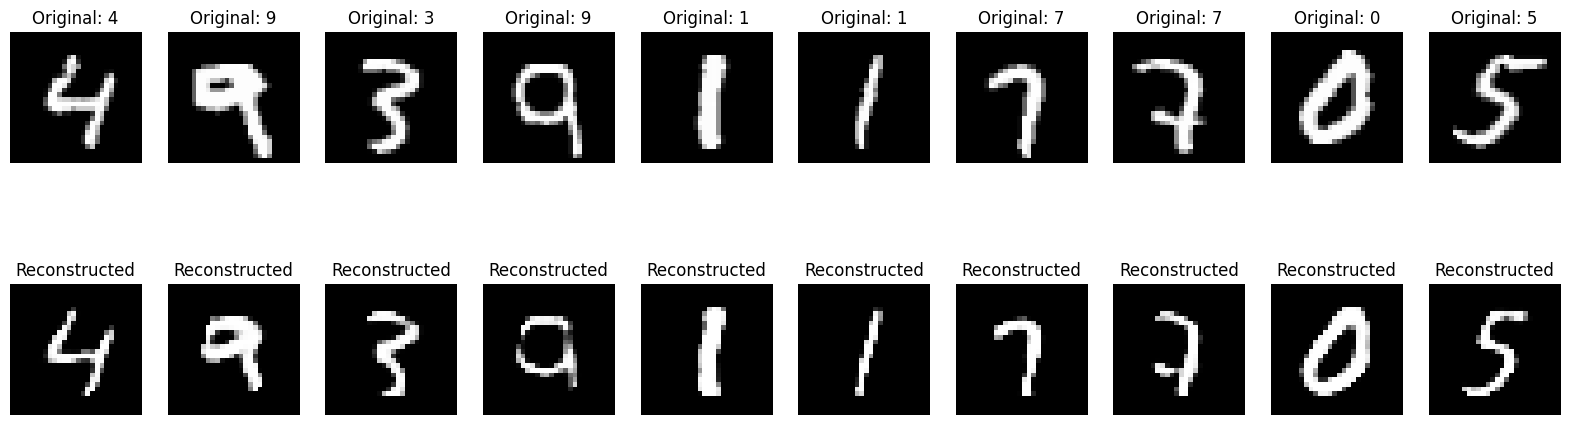

In [7]:
autoencoder_model.eval()
with torch.no_grad():
    all_images, all_labels = next(iter(DataLoader(testing_dataset, batch_size=len(testing_dataset))))
    all_images = all_images.to(device)

    all_reconstructed, _ = autoencoder_model(all_images)

    all_images = all_images.cpu()
    all_reconstructed = all_reconstructed.cpu()

    display_images = 10
    indices = np.random.choice(len(all_images), display_images, replace=False)

    plt.figure(figsize=(20, 6))

    for i, idx in enumerate(indices):
        ax = plt.subplot(2, display_images, i + 1)
        plt.imshow(all_images[idx].squeeze(), cmap='gray')
        plt.title(f"Original: {all_labels[idx].item()}")
        plt.axis('off')

        ax = plt.subplot(2, display_images, i + 1 + display_images)
        plt.imshow(all_reconstructed[idx].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()

Part A-2 : Hidden (latent) dimension of 64

In [8]:
autoencoder_model2 = SparseAutoencoder(feature_dim=64).to(device)
optimizer2 = optim.Adam(autoencoder_model2.parameters(), lr=0.001)
scheduler2 = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=2, verbose=True)

train_autoencoder(autoencoder_model2, optimizer2, scheduler2)

Epoch [1/20], Loss: 0.9048, Learning Rate: 0.001
New minimum loss: 0.9048
Epoch [2/20], Loss: 0.8766, Learning Rate: 0.001
New minimum loss: 0.8766
Epoch [3/20], Loss: 0.8715, Learning Rate: 0.001
New minimum loss: 0.8715
Epoch [4/20], Loss: 0.8690, Learning Rate: 0.001
New minimum loss: 0.8690
Epoch [5/20], Loss: 0.8669, Learning Rate: 0.001
New minimum loss: 0.8669
Epoch [6/20], Loss: 0.8655, Learning Rate: 0.001
New minimum loss: 0.8655
Epoch [7/20], Loss: 0.8644, Learning Rate: 0.001
New minimum loss: 0.8644
Epoch [8/20], Loss: 0.8632, Learning Rate: 0.001
New minimum loss: 0.8632
Epoch [9/20], Loss: 0.8622, Learning Rate: 0.001
New minimum loss: 0.8622
Epoch [10/20], Loss: 0.8614, Learning Rate: 0.001
New minimum loss: 0.8614
Epoch [11/20], Loss: 0.8607, Learning Rate: 0.001
New minimum loss: 0.8607
Epoch [12/20], Loss: 0.8598, Learning Rate: 0.001
New minimum loss: 0.8598
Epoch [13/20], Loss: 0.8591, Learning Rate: 0.001
New minimum loss: 0.8591
Epoch [14/20], Loss: 0.8583, Learn

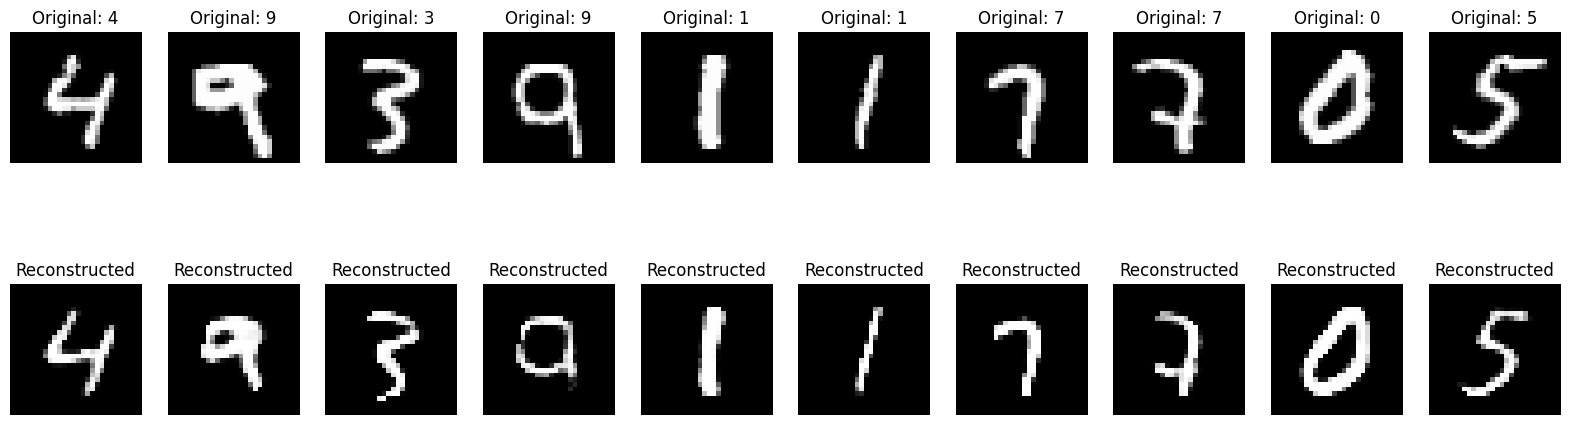

In [9]:
autoencoder_model2.eval()

with torch.no_grad():
    all_images = all_images.to(device)

    all_reconstructed2, _ = autoencoder_model2(all_images)

    all_images = all_images.cpu()
    all_reconstructed2 = all_reconstructed2.cpu()

    display_images_2 = display_images
    indices_2 = indices

    plt.figure(figsize=(20, 6))

    for i, idx in enumerate(indices_2):
        ax = plt.subplot(2, display_images_2, i + 1)
        plt.imshow(all_images[idx].squeeze(), cmap='gray')
        plt.title(f"Original: {all_labels[idx].item()}")
        plt.axis('off')

        ax = plt.subplot(2, display_images_2, i + 1 + display_images_2)
        plt.imshow(all_reconstructed2[idx].squeeze(), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')

    plt.show()


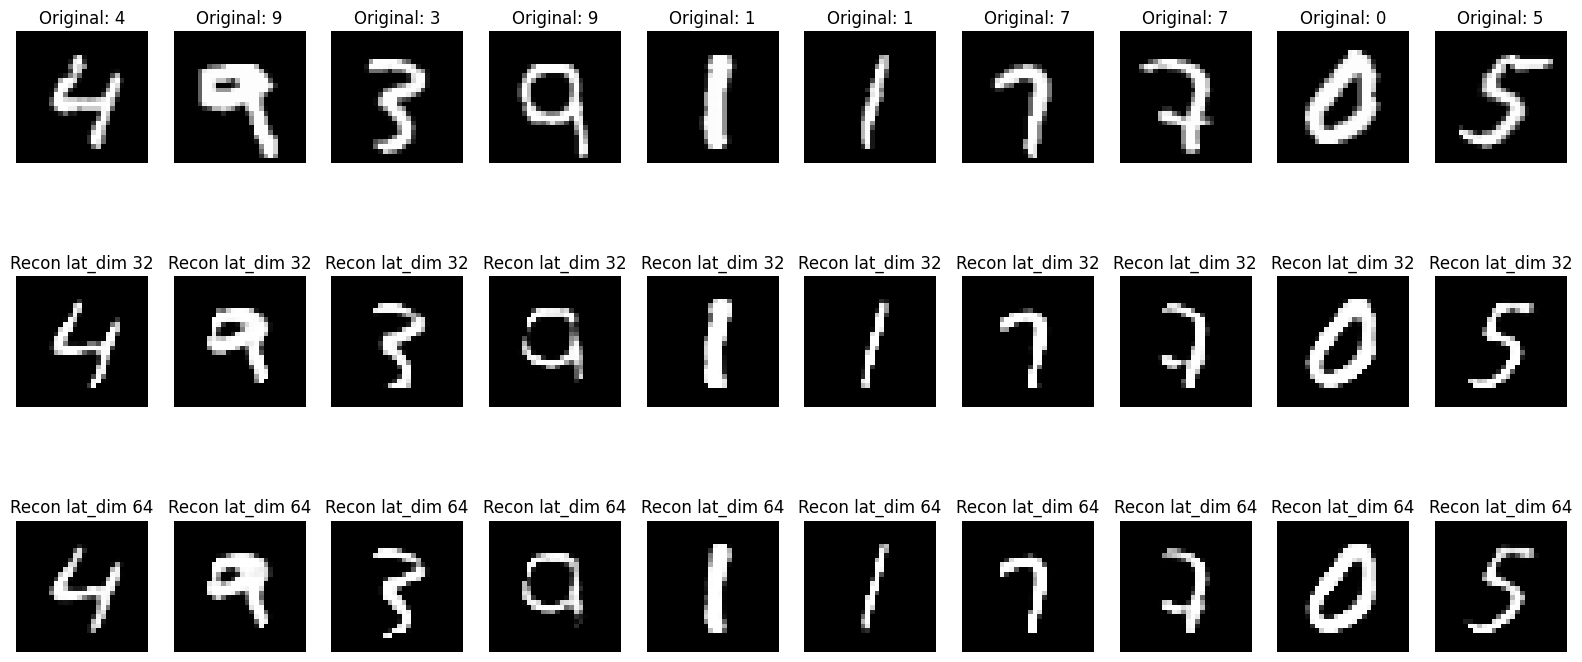

In [10]:

comp_img = 10
comp_indices = indices

plt.figure(figsize=(20, 9))

for i, idx in enumerate(comp_indices):
    ax = plt.subplot(3, comp_img, i + 1)
    plt.imshow(all_images[idx].squeeze(), cmap='gray')
    plt.title(f"Original: {all_labels[idx].item()}")
    plt.axis('off')

    ax = plt.subplot(3, comp_img, i + 1 + comp_img)
    plt.imshow(all_reconstructed[idx].squeeze(), cmap='gray')
    plt.title("Recon lat_dim 32")
    plt.axis('off')

    ax = plt.subplot(3, comp_img, i + 1 + 2 * comp_img)
    plt.imshow(all_reconstructed2[idx].squeeze(), cmap='gray')
    plt.title("Recon lat_dim 64")
    plt.axis('off')

plt.show()

Q1(b)Perform the reconstruction on the line joining two training data samples in the hidden space.
Consider at least 5 pairs of samples.

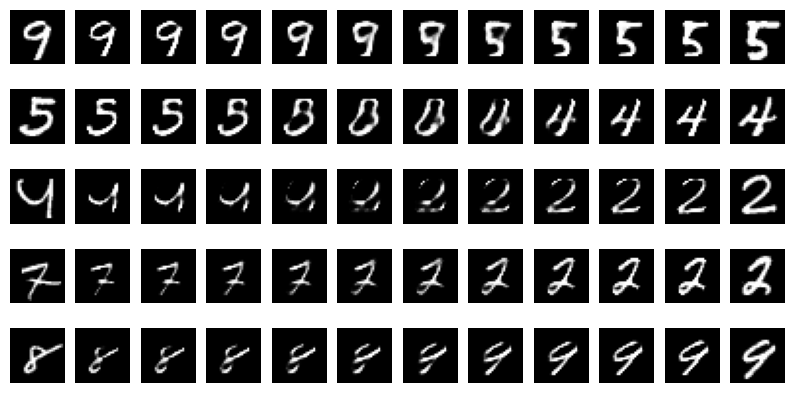

In [33]:
autoencoder_model.eval()

def interpolate_points(p1, p2, n_steps=10):
    """ Linear interpolation between two points in latent space using PyTorch """
    ratios = torch.linspace(0, 1, steps=n_steps, device=p1.device)
    vectors = [(1 - r) * p1 + r * p2 for r in ratios]
    return torch.stack(vectors)

def visualize_interpolation(model, pair_idx, n_interpolations=10):
    fig, axs = plt.subplots(len(pair_idx), n_interpolations + 2, figsize=(10, 1 * len(pair_idx)))

    for i, (idx1, idx2) in enumerate(pair_idx):

        img1, img2 = training_dataset[idx1][0].to(device), training_dataset[idx2][0].to(device)
        imgs = torch.stack([img1, img2])


        with torch.no_grad():
            _, img1_encoded = model(imgs[0].unsqueeze(0))
            _, img2_encoded = model(imgs[1].unsqueeze(0))

        interpolated = interpolate_points(img1_encoded.squeeze(0), img2_encoded.squeeze(0), n_interpolations)

        interpolated_imgs = model.decoder(interpolated).cpu().detach().view(-1, 28, 28)

        axs[i, 0].imshow(img1.cpu().detach().reshape(28, 28), cmap='gray')
        axs[i, 0].axis('off')
        axs[i, n_interpolations + 1].imshow(img2.cpu().detach().reshape(28, 28), cmap='gray')
        axs[i, n_interpolations + 1].axis('off')

        for j, img in enumerate(interpolated_imgs):
            axs[i, j + 1].imshow(img, cmap='gray')
            axs[i, j + 1].axis('off')

    plt.show()

np.random.seed(20)
pair_indices = [np.random.choice(len(training_dataset), 2, replace=False) for _ in range(5)]

visualize_interpolation(autoencoder_model, pair_indices)

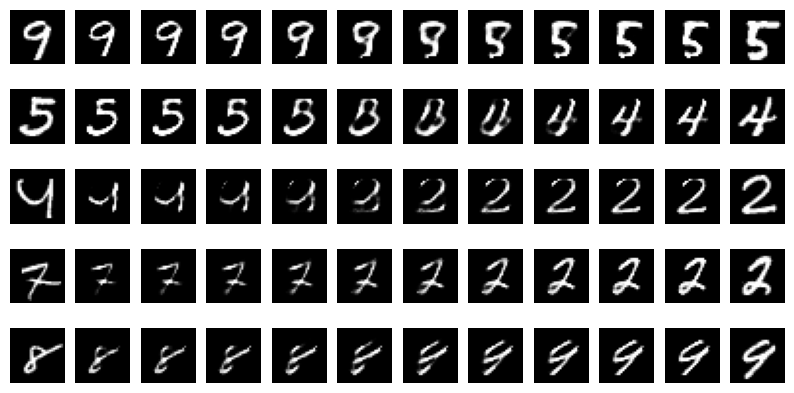

In [34]:
autoencoder_model2.eval()

visualize_interpolation(autoencoder_model2, pair_indices)

Q 2 : Variational Autoencoder (VAE): Train a VAE (on MNIST dataset) for the tasks of generating MNIST-like digits. Encoder learns a distribution in 16D space. After successfully training the
VAE, generate 64 images and display.

In [18]:
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms


In [14]:
class ConvolutionalVAE(nn.Module):
    def __init__(self):
        super(ConvolutionalVAE, self).__init__()

        self.encoder_net = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(16, 32, kernel_size=3, stride=2, padding=1),
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(1568, 784),
            nn.ReLU(),
            nn.Linear(784, 64),
            nn.ReLU(),
            nn.Linear(64, 32)
        )

        self.decoder_net = nn.Sequential(
            nn.Linear(16, 64),
            nn.ReLU(),
            nn.Linear(64, 784),
            nn.ReLU(),
            nn.Linear(784, 1568),
            nn.ReLU(),
            nn.Unflatten(1, (32, 7, 7)),
            nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Sigmoid()
        )

    def reparameterize(self, mu, log_var):
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        x = self.encoder_net(x)
        mu = x[:, :16]
        log_var = x[:, 16:]
        z = self.reparameterize(mu, log_var)
        return self.decoder_net(z), mu, log_var


In [15]:
def vae_loss(reconstructed, original, mu, log_var):
    bce_loss = F.binary_cross_entropy(reconstructed, original, reduction='sum')
    kld_loss = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    return bce_loss + kld_loss


In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

model = ConvolutionalVAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.5, patience=5, threshold=0.01, cooldown=2, min_lr=0.00001, verbose=True)

transform = transforms.Compose([
    transforms.ToTensor(),
])
train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
test_data = datasets.MNIST('./data', train=False, transform=transform)
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=True)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:00<00:00, 15952005.24it/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 459179.53it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:00<00:00, 4378662.36it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 12141828.41it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [19]:
error_log, kl_divergence_log, num_weight_updates, test_losses, updates_recorded = [], [], [], [], []
iteration_count = 0

def train_model(epoch):
    model.train()
    global iteration_count
    for batch_index, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        reconstructed, mu, logvar = model(data)
        loss = vae_loss(reconstructed, data, mu, logvar)
        loss.backward()
        optimizer.step()

        error = F.binary_cross_entropy(reconstructed, data, reduction='sum').item()
        kl_divergence = (-0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())).item()
        error_log.append(error / data.size(0))
        kl_divergence_log.append(kl_divergence / data.size(0))
        num_weight_updates.append(iteration_count)
        iteration_count += 1

def validate_model():
    model.eval()
    validation_loss = 0
    with torch.no_grad():
        for data, _ in test_loader:
            data = data.to(device)
            recon, mu, logvar = model(data)
            validation_loss += vae_loss(recon, data, mu, logvar).item()
    validation_loss /= len(test_loader.dataset)
    print(f'Test set loss: {validation_loss}')
    test_losses.append(validation_loss)
    updates_recorded.append(len(updates_recorded) + 1)
    return validation_loss

for epoch in range(1, 11):
    train_model(epoch)
    avg_loss = validate_model()
    scheduler.step(avg_loss)


Test set loss: 145.14294438476563
Test set loss: 126.9912458984375
Test set loss: 121.83149921875
Test set loss: 118.81584426269531
Test set loss: 117.0264588623047
Test set loss: 116.164590234375
Test set loss: 115.56080609130859
Test set loss: 114.71349401855468
Test set loss: 113.27345316162109
Test set loss: 113.68125327148438


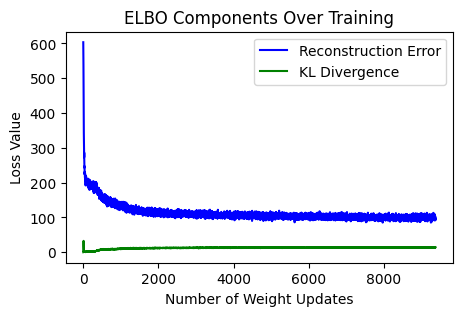

In [22]:
plt.figure(figsize=(5,3), dpi=100)
plt.plot(num_weight_updates, error_log, 'b', label='Reconstruction Error')
plt.plot(num_weight_updates, kl_divergence_log, 'g', label='KL Divergence')
plt.title('ELBO Components Over Training')
plt.xlabel('Number of Weight Updates')
plt.ylabel('Loss Value')
plt.legend()
plt.show()


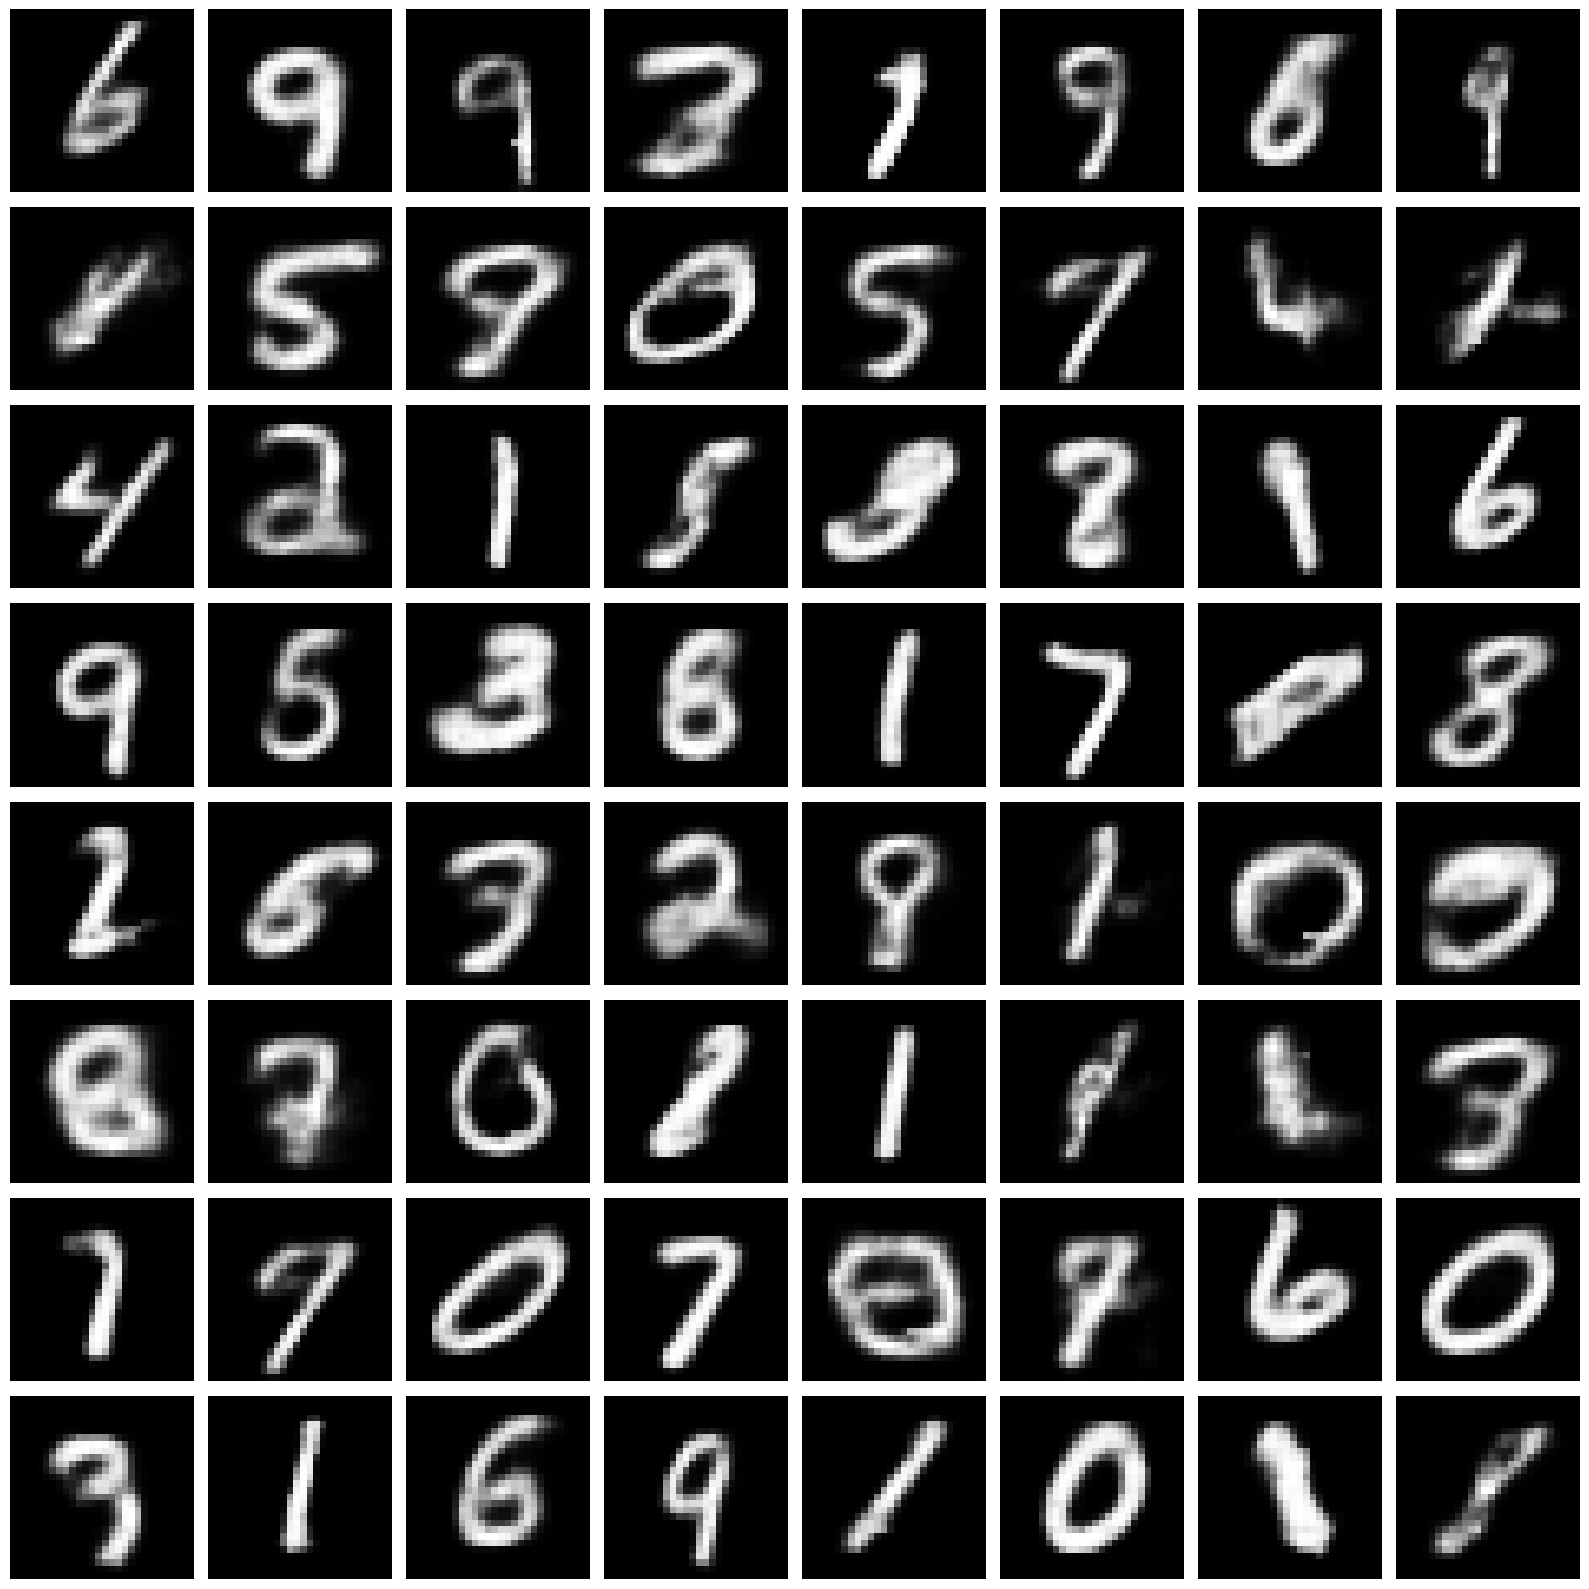

In [23]:
fig, axes = plt.subplots(nrows=8, ncols=8, figsize=(16, 16))
axes = axes.flatten()
for i in range(64):
    z_sample = torch.randn(1, 16).to(device)
    generated_image = model.decoder_net(z_sample)[0].view(28, 28).cpu().detach().numpy()
    ax = axes[i]
    ax.imshow(generated_image, cmap='gray')
    ax.axis('off')
plt.tight_layout()
plt.show()
